In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

import sys
if '..' not in sys.path:
    sys.path.append('..')


import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import matplotlib
import matplotlib.pyplot as plt
import re
# import multiprocessing

# from lib.mobilitysim import MobilitySimulator
from lib.dynamics import DiseaseModel
from lib.distributions import CovidDistributions
from lib.plot import Plotter
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, 
    BetaMultiplierMeasure, 
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForKGroups,
    SocialDistancingByAgeMeasure,
    SocialDistancingForPositiveMeasure, 
    ComplianceForAllMeasure,
    Interval)
from lib.runutils import save_summary, load_summary


# from lib.mobilitysim import MobilitySimulator
# from lib.town_data import generate_population, generate_sites, compute_distances
# from lib.town_maps import MapIllustrator

In [5]:
# Plot results of experiments_server_6-1.py
summaries_SD_5 = load_summary('summaries_r12.pk')

start_date = '2020-03-08'
end_date = '2020-03-27'

isolation_days = [7] # how many days selected people have to stay in isolation
contacts_isolated = [10,25] # how many contacts are isolated in the `test_smart_delta` window
duration_weeks_SD_5 = 12 # strategies tested for 12 weeks starting today
FIGSIZE=(6, 4)
c=0
runstr = f'run{c}_'

plotter = Plotter()
for i, days in enumerate(isolation_days):
    for j, contacts in enumerate(contacts_isolated):
        summaries_ = summaries_SD_5[(days, contacts)]
        titles_SD_5_ = ['No contact tracing', 'Basic contact tracing', 'Advanced contact tracing']
        plotter.compare_total_infections(
            summaries_,
            start_date=start_date,
            titles=titles_SD_5_, 
            figtitle=(f'Strategies for isolating {contacts} contacts.\n'
                      f'Selected people are isolated for {days} days.'),
            filename=runstr + f'SD_5{i}{j}', 
            figsize=FIGSIZE, acc=500, 
            ymax=5000, errorevery=14)

FileNotFoundError: [Errno 2] No such file or directory: 'summaries/summaries_r12.pk'

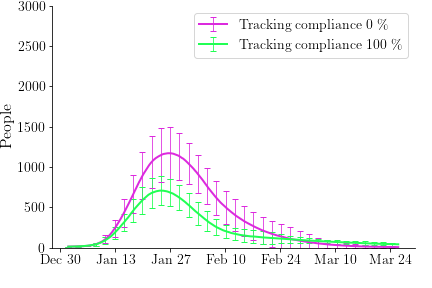

In [149]:
# Plot results of experiments_server_7-1.py
import matplotlib.pyplot as plt

c=0
runstr = f'run{c}_'
summaries_SD_6 = load_summary('summaries_SD_5.pk')
FIGSIZE=(6, 4)

p_compliance = [0.0, 1.0]
plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' individuals compliant with contact-tracing'),
        filename=runstr + f'SD_6{j}'+'contact_details_1', 
        figsize=FIGSIZE, acc=500, 
        ymax=3000, errorevery=14)
    
    
plt.show()

In [59]:
is_traced_fiver = {
            '5':  [[[] for i in range(3)] for i in range(5)]# np.zeros((5, 3), dtype='float')
        }
is_traced_one = {
            '1':  [[] for i in range(3)]# np.zeros((5, 3), dtype='float')
        }
is_traced_two = {
            '2':  [[] for i in range(3)]# np.zeros((5, 3), dtype='float')
        }


is_traced_one['1'][0].append(0.1)
is_traced_one['1'][0].append(0.2) # person #0 is traced twice, start at 0.1, and 0.2, respectively

is_traced_two['2'][1].append(0.3)
is_traced_two['2'][2].append(0.4)

for r in range(5):
    print(is_traced_fiver['5'][r])
    is_traced_fiver['5'][r] = is_traced_two['2']

print(is_traced_oner)
print(is_traced_fiver)

# print(dir(summary))

[[], [], []]
[[], [], []]
[[], [], []]
[[], [], []]
[[], [], []]
{'1': [[0.1, 0.2], [], []]}
{'5': [[[], [0.3], [0.4]], [[], [0.3], [0.4]], [[], [0.3], [0.4]], [[], [0.3], [0.4]], [[], [0.3], [0.4]]]}
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'children_count_iasy', 'children_count_ipre', 'children_count_isym', 'dynamic_tracing', 'essential_workers', 'home_loc', 'is_traced', 'is_traced_state', 'max_time', 'measure_list', 'mob', 'n_people', 'n_sites', 'people_age', 'random_repeats', 'site_loc', 'state', 'state_ended_at', 'state_started_at', 'trace_ended_at', 'trace_started_at']


<ipython-input-2-2e6fa06eee68>:121: RuntimeWarning: invalid value encountered in double_scalars
  +str(round((np.nansum(avg_traced_noninfectious_states)/alll)*100,2))+'\%', color='tab:blue')
<ipython-input-2-2e6fa06eee68>:124: RuntimeWarning: invalid value encountered in double_scalars
  +str(round((np.nansum(avg_traced_infectious_states)/alll)*100,2))+'\%', color='tab:red')
<ipython-input-2-2e6fa06eee68>:128: RuntimeWarning: invalid value encountered in double_scalars
  +str(round((np.nansum(avg_traced_noninfectious_states_essential)/alll)*100,2))+'\%', color='tab:blue')
<ipython-input-2-2e6fa06eee68>:131: RuntimeWarning: invalid value encountered in double_scalars
  +str(round((np.nansum(avg_traced_infectious_states_essential)/alll)*100,2))+'\%', color='tab:red')
<ipython-input-2-2e6fa06eee68>:135: RuntimeWarning: invalid value encountered in double_scalars
  +str(round((np.nansum(avg_traced_noninfectious_states_normal)/alll)*100,2))+'\%', color='tab:blue')
<ipython-input-2-2e6fa06ee

{'susc': 0, 'expo': 0, 'ipre': 0, 'isym': 0, 'iasy': 0, 'posi': 0, 'nega': 0, 'resi': 0, 'dead': 0, 'hosp': 0}
{'susc': 0.3839598213849505, 'expo': 0.10081002120320887, 'ipre': 0.05469059925935283, 'isym': 0.049607691781557765, 'iasy': 0.06938823368476536, 'posi': 0.12377202153542537, 'nega': 0.0, 'resi': 0.21775988587397405, 'dead': 0.0, 'hosp': 1.1725276765387006e-05}


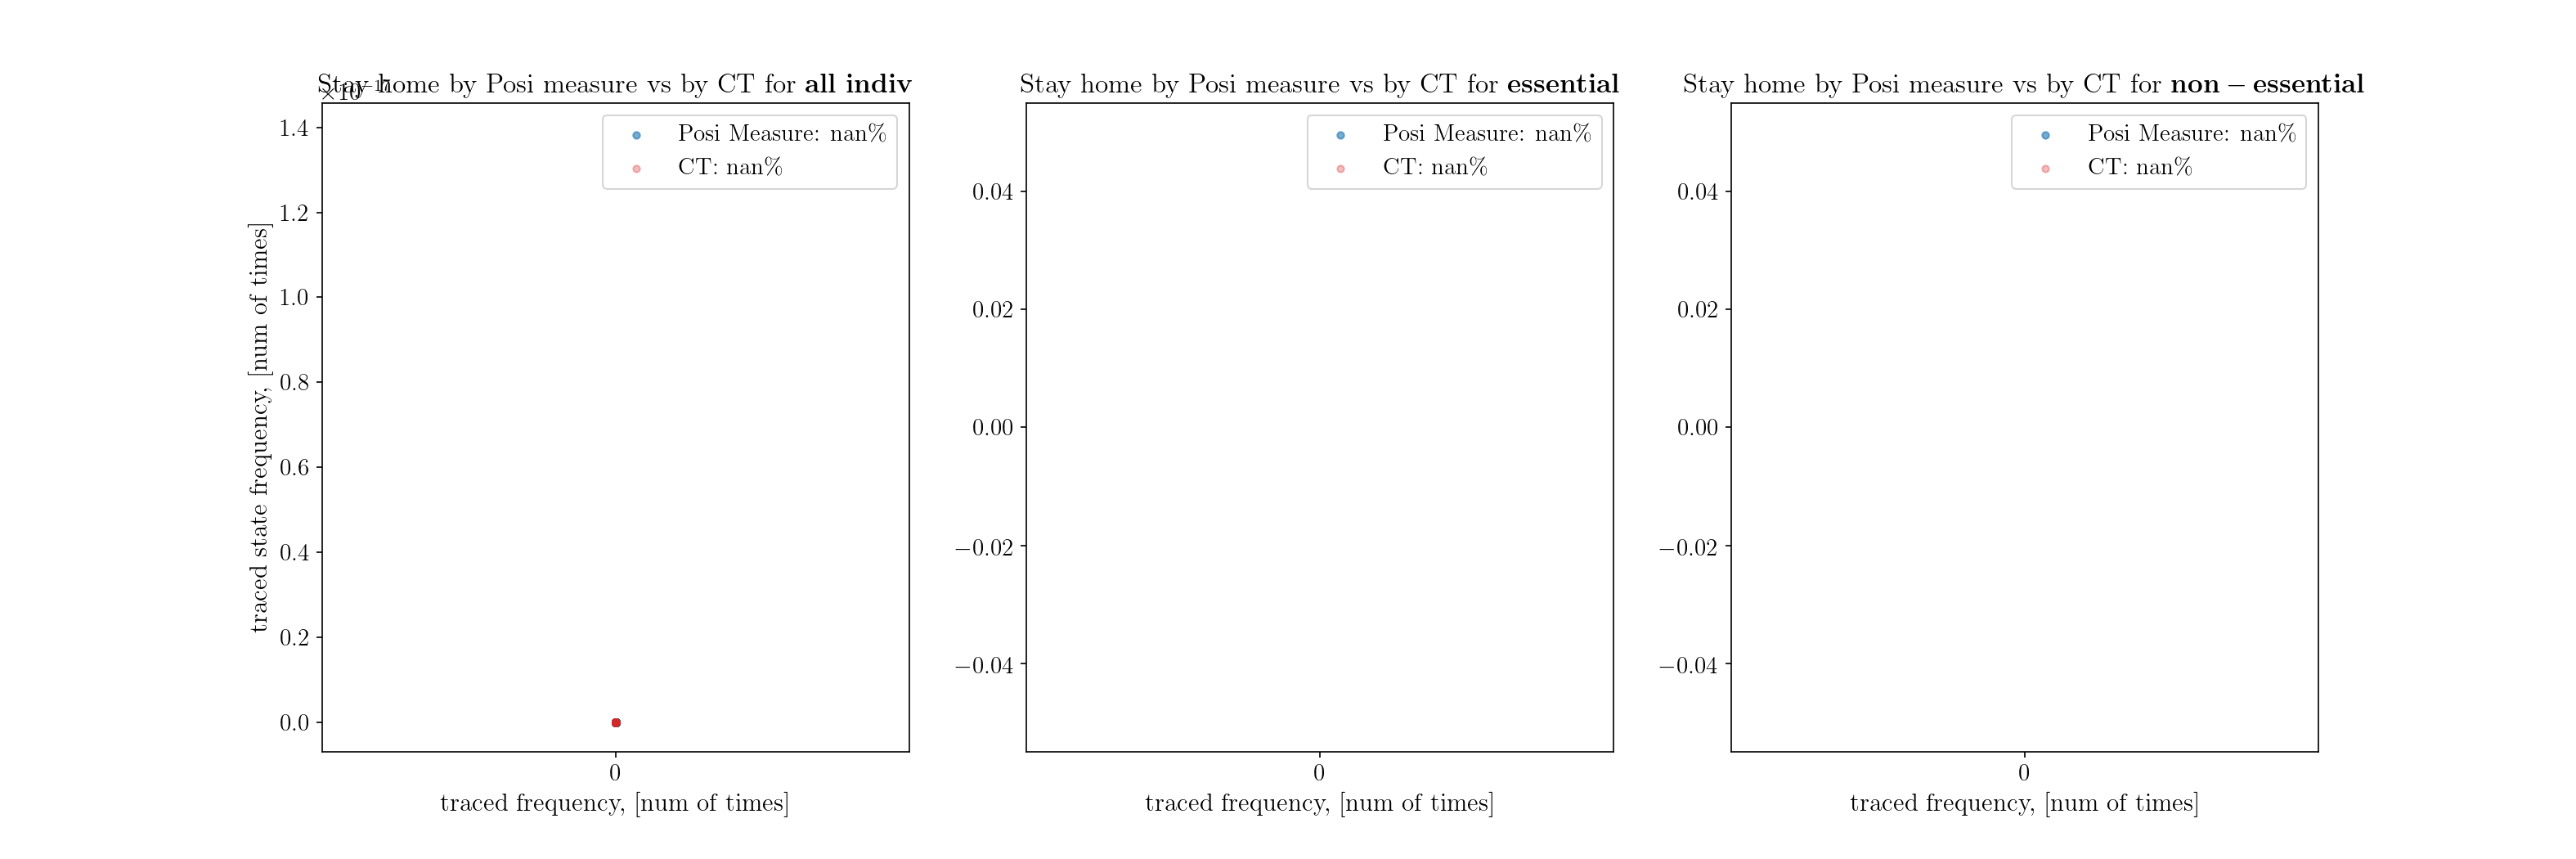

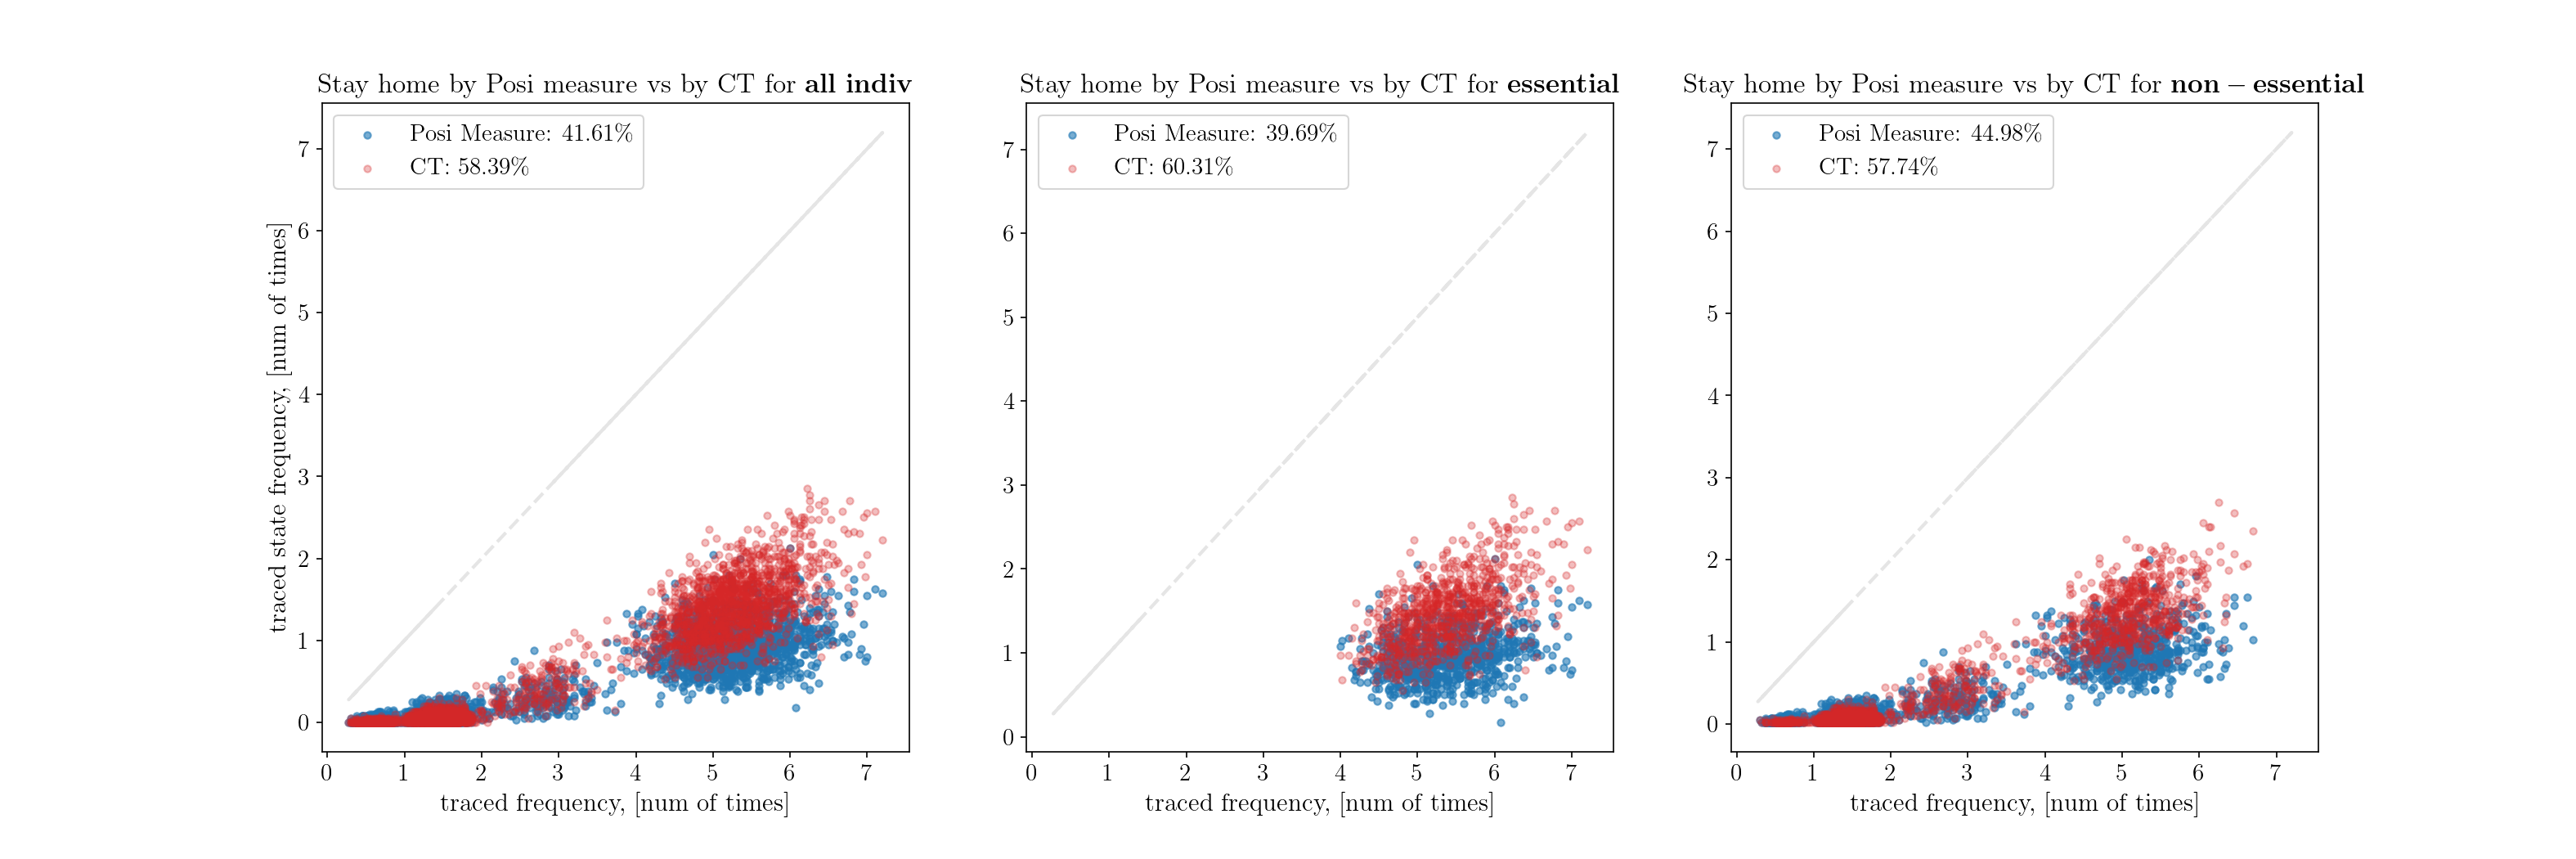

In [2]:
c=0
runstr = f'run{c}_'
summaries_SD_6 = load_summary('summaries_SD_5.pk')
# titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])

p_compliance = [0.0, 1.0]
all_states = ['susc', 'expo', 'ipre', 'isym', 'iasy', 'posi', 'nega', 'resi', 'dead', 'hosp']
infectious_states =['ipre','isym','iasy']  # ['ipre', 'isym', 'iasy', 'posi']
noninfectious_states = ['posi']# ['susc', 'expo', 'nega', 'resi', 'dead', 'hosp']
plot_states ='seperate_infectious_noninfectious' #'combine_infectious_states' #['susc', 'expo', 'ipre', 'isym', 'iasy', 'posi', 'resi']
alphas = np.linspace(0.6,0.3,num=len(plot_states))

plotter = Plotter()
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
#     f,axs = plt.subplots(1,len(p_compliance),figsize = (13,5))    
    for c, summary in enumerate(summaries_):     # each compliance rate
        fig = plt.figure(figsize=(21,7))
        axs1 = fig.add_subplot(131)
        axs2 = fig.add_subplot(132)
        axs3 = fig.add_subplot(133)
        
        avg_traced_times = np.zeros(summary.n_people)        
        avg_traced_all_states = {cur_state: np.zeros(summary.n_people) for cur_state in all_states}
        avg_traced_all_states_essential = {cur_state: np.zeros(summary.n_people) for cur_state in all_states}
        avg_traced_all_states_normal = {cur_state: np.zeros(summary.n_people) for cur_state in all_states}
        avg_traced_infectious_states = np.zeros(summary.n_people)
        avg_traced_infectious_states_essential = np.zeros(summary.n_people)
        avg_traced_infectious_states_normal = np.zeros(summary.n_people)
        avg_traced_noninfectious_states = np.zeros(summary.n_people)
        avg_traced_noninfectious_states_essential = np.zeros(summary.n_people)
        avg_traced_noninfectious_states_normal = np.zeros(summary.n_people)
        sum_all_states = 0
        sum_all_states_essential = 0
        sum_all_states_normal = 0
        traced_all_states_ratio = {cur_state: np.zeros(1) for cur_state in all_states}
        traced_all_states_ratio_essential = {cur_state: np.zeros(1) for cur_state in all_states}
        traced_all_states_ratio_normal = {cur_state: np.zeros(1) for cur_state in all_states}
        traced_plot_states_ratio = {cur_state: np.zeros(1) for cur_state in plot_states}
        traced_plot_states_ratio_essential = {cur_state: np.zeros(1) for cur_state in plot_states}
        traced_plot_states_ratio_normal = {cur_state: np.zeros(1) for cur_state in plot_states}
        
        for r in range(summary.random_repeats):  # each repeat
            avg_traced_times += summary.is_traced['trace'][r]
            for cur_state in all_states:
                avg_traced_all_states[cur_state] += summary.is_traced_state[cur_state][r]            
            
        avg_traced_times /= summary.random_repeats
        for cur_state in all_states:
            # traced times for all indiv at all states
            avg_traced_all_states[cur_state] /= summary.random_repeats 
            # seperate essential and normal
            avg_traced_all_states_essential[cur_state] = np.multiply(avg_traced_all_states[cur_state],summary.essential_workers[0])
            avg_traced_all_states_normal[cur_state] = np.multiply(avg_traced_all_states[cur_state],1-summary.essential_workers[0])
            
#             sum_all_states += np.count_nonzero(avg_traced_all_states[cur_state])
#             traced_all_states_ratio[cur_state] = np.count_nonzero(avg_traced_all_states[cur_state])
#             sum_all_states_essential += np.count_nonzero(~np.isnan(avg_traced_all_states_essential[cur_state]))
#             sum_all_states_normal += np.count_nonzero(~np.isnan(avg_traced_all_states_normal[cur_state]))
#             traced_all_states_ratio_essential[cur_state] = np.count_nonzero(~np.isnan(avg_traced_all_states_essential[cur_state]))
#             traced_all_states_ratio_normal[cur_state] = np.count_nonzero(~np.isnan(avg_traced_all_states_normal[cur_state]))
            sum_all_states += sum((avg_traced_all_states[cur_state]))
            traced_all_states_ratio[cur_state] = sum((avg_traced_all_states[cur_state])) # to be discussed
            sum_all_states_essential += sum((avg_traced_all_states_essential[cur_state]))
            sum_all_states_normal += sum((avg_traced_all_states_normal[cur_state]))
            traced_all_states_ratio_essential[cur_state] = sum((avg_traced_all_states_essential[cur_state]))
            traced_all_states_ratio_normal[cur_state] = sum((avg_traced_all_states_normal[cur_state]))
       
        for cur_state in all_states:
            if sum_all_states != 0:
                traced_all_states_ratio[cur_state] /= sum_all_states
                traced_all_states_ratio_essential[cur_state] /= sum_all_states_essential
                traced_all_states_ratio_normal[cur_state] /= sum_all_states_normal
            else:
                traced_all_states_ratio[cur_state] = 0
                traced_all_states_ratio_essential[cur_state] = 0
                traced_all_states_ratio_normal[cur_state] = 0
         
        
        for cur_state in infectious_states:
            avg_traced_infectious_states += avg_traced_all_states[cur_state]
            avg_traced_infectious_states_essential = np.multiply(avg_traced_infectious_states,summary.essential_workers[0])
            avg_traced_infectious_states_normal = np.multiply(avg_traced_infectious_states,1-summary.essential_workers[0])
            avg_traced_infectious_states_essential[avg_traced_infectious_states_essential==0] = 'nan'
            avg_traced_infectious_states_normal[avg_traced_infectious_states_normal==0] = 'nan'
        for cur_state in noninfectious_states:
            avg_traced_noninfectious_states += avg_traced_all_states[cur_state]
            avg_traced_noninfectious_states_essential = np.multiply(avg_traced_noninfectious_states,summary.essential_workers[0])
            avg_traced_noninfectious_states_normal = np.multiply(avg_traced_noninfectious_states,1-summary.essential_workers[0])
            avg_traced_noninfectious_states_essential[avg_traced_noninfectious_states_essential==0] = 'nan'
            avg_traced_noninfectious_states_normal[avg_traced_noninfectious_states_normal==0] = 'nan'
            
        
        
        ## plot
        axs1.plot(avg_traced_times,avg_traced_times,linestyle='--',color='black',alpha=0.1)
        axs2.plot(avg_traced_times,avg_traced_times,linestyle='--',color='black',alpha=0.1)
        axs3.plot(avg_traced_times,avg_traced_times,linestyle='--',color='black',alpha=0.1)
        if plot_states == 'combine_infectious_states':
            axs1.scatter(avg_traced_times, avg_traced_infectious_states_essential, 
                               alpha=alphas[i], edgecolors=None, label=cur_state, color='tab:blue')
            axs1.scatter(avg_traced_times, avg_traced_infectious_states_essential, 
                               alpha=alphas[i], edgecolors=None, label=cur_state, color='tab:red')            
            axs2.scatter(avg_traced_times, avg_traced_infectious_states_essential, 
                               alpha=alphas[i], edgecolors=None, label=cur_state, color='tab:red')
            axs3.scatter(avg_traced_times, avg_traced_infectious_states_normal, 
                               alpha=alphas[i], edgecolors=None, label=cur_state, color='tab:blue')
            axs1.set_title('infectious traced freq for all indiv')
            axs2.set_title('infectious traced freq for essential')
            axs3.set_title('infectious traced freq for non essential')
        elif plot_states == 'nonzero_states':
            for i, cur_state in enumerate(all_states):
                if sum(avg_traced_all_states[cur_state]) != 0:
                    axs.scatter(avg_traced_times, avg_traced_all_states[cur_state], 
                               alpha=alphas[i], edgecolors=None, label=cur_state)
                    axs.legend()
        elif plot_states == 'seperate_infectious_noninfectious':
            alll = np.nansum(avg_traced_noninfectious_states + avg_traced_infectious_states)
            axs1.scatter(avg_traced_times, avg_traced_noninfectious_states, 
                               alpha=0.6, edgecolors=None, label='Posi Measure: '
                         +str(round((np.nansum(avg_traced_noninfectious_states)/alll)*100,2))+'\%', color='tab:blue')
            axs1.scatter(avg_traced_times, avg_traced_infectious_states, 
                               alpha=0.3, edgecolors=None, label='CT: '
                         +str(round((np.nansum(avg_traced_infectious_states)/alll)*100,2))+'\%', color='tab:red')  
            alll = np.nansum(avg_traced_noninfectious_states_essential + avg_traced_infectious_states_essential)
            axs2.scatter(avg_traced_times, avg_traced_noninfectious_states_essential, 
                               alpha=0.6, edgecolors=None, label='Posi Measure: '
                         +str(round((np.nansum(avg_traced_noninfectious_states_essential)/alll)*100,2))+'\%', color='tab:blue')
            axs2.scatter(avg_traced_times, avg_traced_infectious_states_essential, 
                               alpha=0.3, edgecolors=None, label='CT: '
                         +str(round((np.nansum(avg_traced_infectious_states_essential)/alll)*100,2))+'\%', color='tab:red')
            alll = np.nansum(avg_traced_noninfectious_states_normal + avg_traced_infectious_states_normal)
            axs3.scatter(avg_traced_times, avg_traced_noninfectious_states_normal,
                               alpha=0.6, edgecolors=None, label='Posi Measure: '
                         +str(round((np.nansum(avg_traced_noninfectious_states_normal)/alll)*100,2))+'\%', color='tab:blue')
            axs3.scatter(avg_traced_times, avg_traced_infectious_states_normal, 
                               alpha=0.3, edgecolors=None, label='CT: '
                         +str(round((np.nansum(avg_traced_infectious_states_normal)/alll)*100,2))+'\%', color='tab:red')
            
        else:
            # compute relative state ratio
            sum_traced_plot_states_ratio = 0
            sum_traced_plot_states_ratio_essential = 0
            sum_traced_plot_states_ratio_normal = 0
            for cur_state in plot_states:
                sum_traced_plot_states_ratio += traced_all_states_ratio[cur_state]
                traced_plot_states_ratio[cur_state] = traced_all_states_ratio[cur_state]
                sum_traced_plot_states_ratio_essential += traced_all_states_ratio_essential[cur_state]
                traced_plot_states_ratio_essential[cur_state] = traced_all_states_ratio_essential[cur_state]
                sum_traced_plot_states_ratio_normal += traced_all_states_ratio_normal[cur_state]
                traced_plot_states_ratio_normal[cur_state] = traced_all_states_ratio_normal[cur_state]
            for cur_state in plot_states:
                avg_traced_all_states_essential[cur_state][avg_traced_all_states_essential[cur_state]==0] = 'nan'
                avg_traced_all_states_normal[cur_state][avg_traced_all_states_normal[cur_state]==0] = 'nan'
                if sum_traced_plot_states_ratio != 0:
                    traced_plot_states_ratio[cur_state] /= sum_traced_plot_states_ratio
                    traced_plot_states_ratio_essential[cur_state] /= sum_traced_plot_states_ratio_essential
                    traced_plot_states_ratio_normal[cur_state] /= sum_traced_plot_states_ratio_normal
            # plot            
            for i, cur_state in enumerate(plot_states):
                axs1.scatter(avg_traced_times, avg_traced_all_states[cur_state], 
                               alpha=alphas[i], edgecolors=None, label=cur_state+': '
                             +str(round(traced_plot_states_ratio[cur_state]*100,2))+'\%')
                axs2.scatter(avg_traced_times, avg_traced_all_states_essential[cur_state], 
                               alpha=alphas[i], edgecolors=None, label=cur_state+': '
                             +str(round(traced_plot_states_ratio_essential[cur_state]*100,2))+'\%')
                axs3.scatter(avg_traced_times, avg_traced_all_states_normal[cur_state], 
                               alpha=alphas[i], edgecolors=None, label=cur_state+': '
                             +str(round(traced_plot_states_ratio_normal[cur_state]*100,2))+'\%')
                
                
        
        axs1.set_title('Stay home by Posi measure vs by CT for ' + r"$\bf{" + 'all\ indiv' + "}$")
        axs2.set_title('Stay home by Posi measure vs by CT for ' + r"$\bf{" + 'essential' + "}$")
        axs3.set_title('Stay home by Posi measure vs by CT for ' + r"$\bf{" + 'non-essential' + "}$")
        axs1.legend()
        axs2.legend()
        axs3.legend()
        axs1.set_xticks(range(0, int(max(avg_traced_times)+1)))
        axs2.set_xticks(range(0, int(max(avg_traced_times)+1)))
        axs3.set_xticks(range(0, int(max(avg_traced_times)+1)))
        axs1.set_xlabel('traced frequency, [num of times]',fontsize = 15)
        axs2.set_xlabel('traced frequency, [num of times]',fontsize = 15)
        axs3.set_xlabel('traced frequency, [num of times]',fontsize = 15)
        axs1.set_ylabel('traced state frequency, [num of times]',fontsize = 15)
#         axs2.set_ylabel('traced state frequency, [num of times]',fontsize = 15)
#         axs3.set_ylabel('traced state frequency, [num of times]',fontsize = 15)
            
#         print(avg_traced_times)
#         print(avg_traced_infectious_states)
        print(traced_all_states_ratio)

        
        
plt.show()

In [3]:
c=0
runstr = f'run{c}_'
TO_HOURS = 24.0
acc=500
summaries_SD_6 = load_summary('summaries_SD_5.pk')
# titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])

p_compliance = [0.0, 1.0]
all_states = ['susc', 'expo', 'ipre', 'isym', 'iasy', 'posi', 'nega', 'resi', 'dead', 'hosp']
infectious_states = ['ipre', 'isym', 'iasy', 'posi']
plot_states = infectious_states #'combine_infectious_states' #['susc', 'expo', 'ipre', 'isym', 'iasy', 'posi', 'resi']
alphas = np.linspace(0.6,0.3,num=len(plot_states))

plotter = Plotter()
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
#     f,axs = plt.subplots(1,len(p_compliance),figsize = (13,5))    
    for c, summary in enumerate(summaries_):     # each compliance rate
#         fig = plt.figure(figsize=(7,21))
#         axs1 = fig.add_subplot(311)
#         axs2 = fig.add_subplot(312)
#         axs3 = fig.add_subplot(313)        
        
        ts, means, stds = [], [], []
        cur_num_of_traced_indiv = np.zeros(summary.random_repeats)
            
        for t in np.linspace(0.0, summary.max_time, num=acc, endpoint=True): # each time
            for r in range(summary.random_repeats):  # each repeat
                repeatr_trace_started_at = summary.trace_started_at['trace'][r]
                repeatr_trace_ended_at = summary.trace_ended_at['trace'][r]
                for i in range(summary.n_people):   # each person
                    if repeatr_trace_started_at[i]:
                        cur_num_of_traced_indiv[r] += np.sum([(repeatr_trace_started_at[i][j]<t) and (repeatr_trace_ended_at[i][j])>t for j in range(len(repeatr_trace_ended_at[i]))])

                           
            ts.append(t/TO_HOURS)
            means.append(np.mean(cur_num_of_traced_indiv))
            stds.append(np.std(cur_num_of_traced_indiv))
            
            
                    
                

In [8]:
print(summary.trace_started_at['trace'][39])

[[456.0], [552.0], [], [384.0, 408.0, 408.0, 1512.0], [], [72.0], [576.0, 600.0, 624.0, 624.0, 1080.0], [432.0, 888.0], [1200.0], [288.0], [792.0], [384.0, 408.0, 432.0, 792.0], [480.0], [288.0, 744.0, 1200.0, 1200.0, 1512.0], [504.0, 864.0, 1080.0, 1776.0], [], [168.0, 192.0, 216.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 432.0, 432.0, 432.0, 480.0, 1104.0, 1104.0, 1128.0], [528.0, 960.0, 1392.0, 1416.0], [408.0], [696.0, 1320.0, 1944.0], [624.0, 960.0, 1416.0], [216.0, 1032.0, 1080.0, 1416.0], [672.0, 1080.0, 1296.0, 1320.0, 1776.0], [360.0], [432.0], [456.0, 480.0, 528.0, 1320.0], [288.0, 648.0, 1200.0, 1800.0], [504.0], [384.0], [432.0], [480.0, 1200.0, 1800.0], [], [120.0, 432.0, 864.0, 1320.0], [72.0, 480.0, 480.0, 504.0, 504.0, 504.0, 504.0, 528.0, 528.0, 528.0, 1344.0], [432.0, 696.0, 1416.0], [456.0, 480.0, 1368.0, 1728.0], [1368.0], [1944.0], [72.0, 1584.0], [456.0, 480.0, 480.0, 480.0, 504.0, 840.0, 1656.0, 1680.0], [312.0, 312.0, 336.0, 624.0, 984.0], [432.0], [], 

In [9]:
print(summary.trace_ended_at['trace'][39])

[[624.0], [720.0], [], [552.0, 576.0, 576.0, 1680.0], [], [240.0], [744.0, 768.0, 792.0, 792.0, 1248.0], [600.0, 1056.0], [1368.0], [456.0], [960.0], [552.0, 576.0, 600.0, 960.0], [648.0], [456.0, 912.0, 1368.0, 1368.0, 1680.0], [672.0, 1032.0, 1248.0, 1944.0], [], [336.0, 360.0, 384.0, 576.0, 576.0, 576.0, 576.0, 576.0, 576.0, 576.0, 600.0, 600.0, 600.0, 648.0, 1272.0, 1272.0, 1296.0], [696.0, 1128.0, 1560.0, 1584.0], [576.0], [864.0, 1488.0, 2112.0], [792.0, 1128.0, 1584.0], [384.0, 1200.0, 1248.0, 1584.0], [840.0, 1248.0, 1464.0, 1488.0, 1944.0], [528.0], [600.0], [624.0, 648.0, 696.0, 1488.0], [456.0, 816.0, 1368.0, 1968.0], [672.0], [552.0], [600.0], [648.0, 1368.0, 1968.0], [], [288.0, 600.0, 1032.0, 1488.0], [240.0, 648.0, 648.0, 672.0, 672.0, 672.0, 672.0, 696.0, 696.0, 696.0, 1512.0], [600.0, 864.0, 1584.0], [624.0, 648.0, 1536.0, 1896.0], [1536.0], [2112.0], [240.0, 1752.0], [624.0, 648.0, 648.0, 648.0, 672.0, 1008.0, 1824.0, 1848.0], [480.0, 480.0, 504.0, 792.0, 1152.0], [60

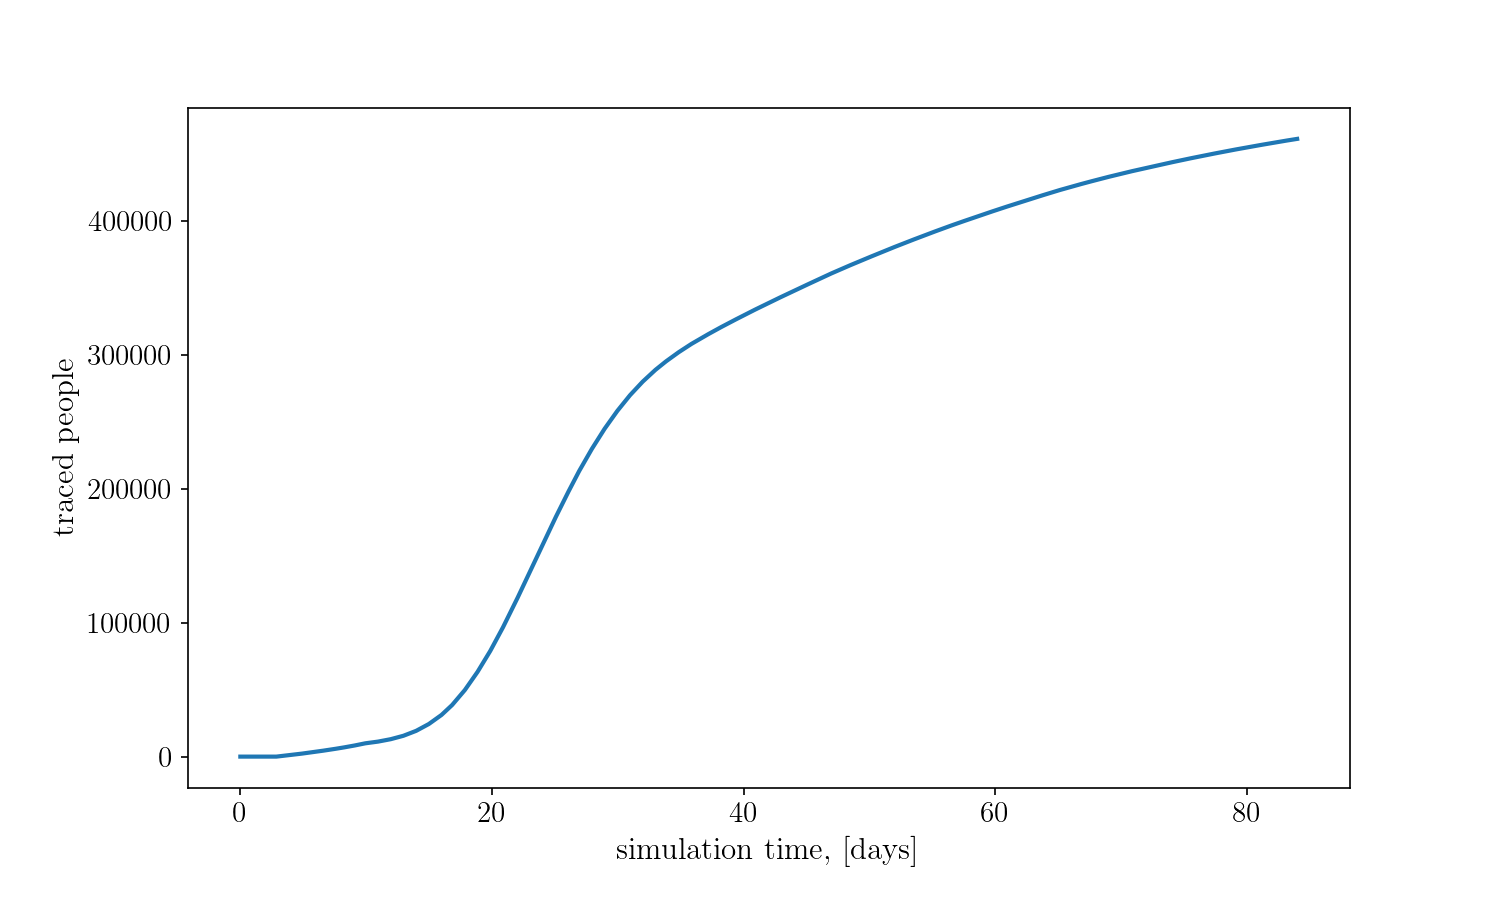

In [4]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# ax.errorbar(ts, means, yerr=stds)
ax.plot(ts,means)
ax.set_xlabel('simulation time, [days]',fontsize = 15)
ax.set_ylabel('traced people',fontsize = 15)
plt.show()

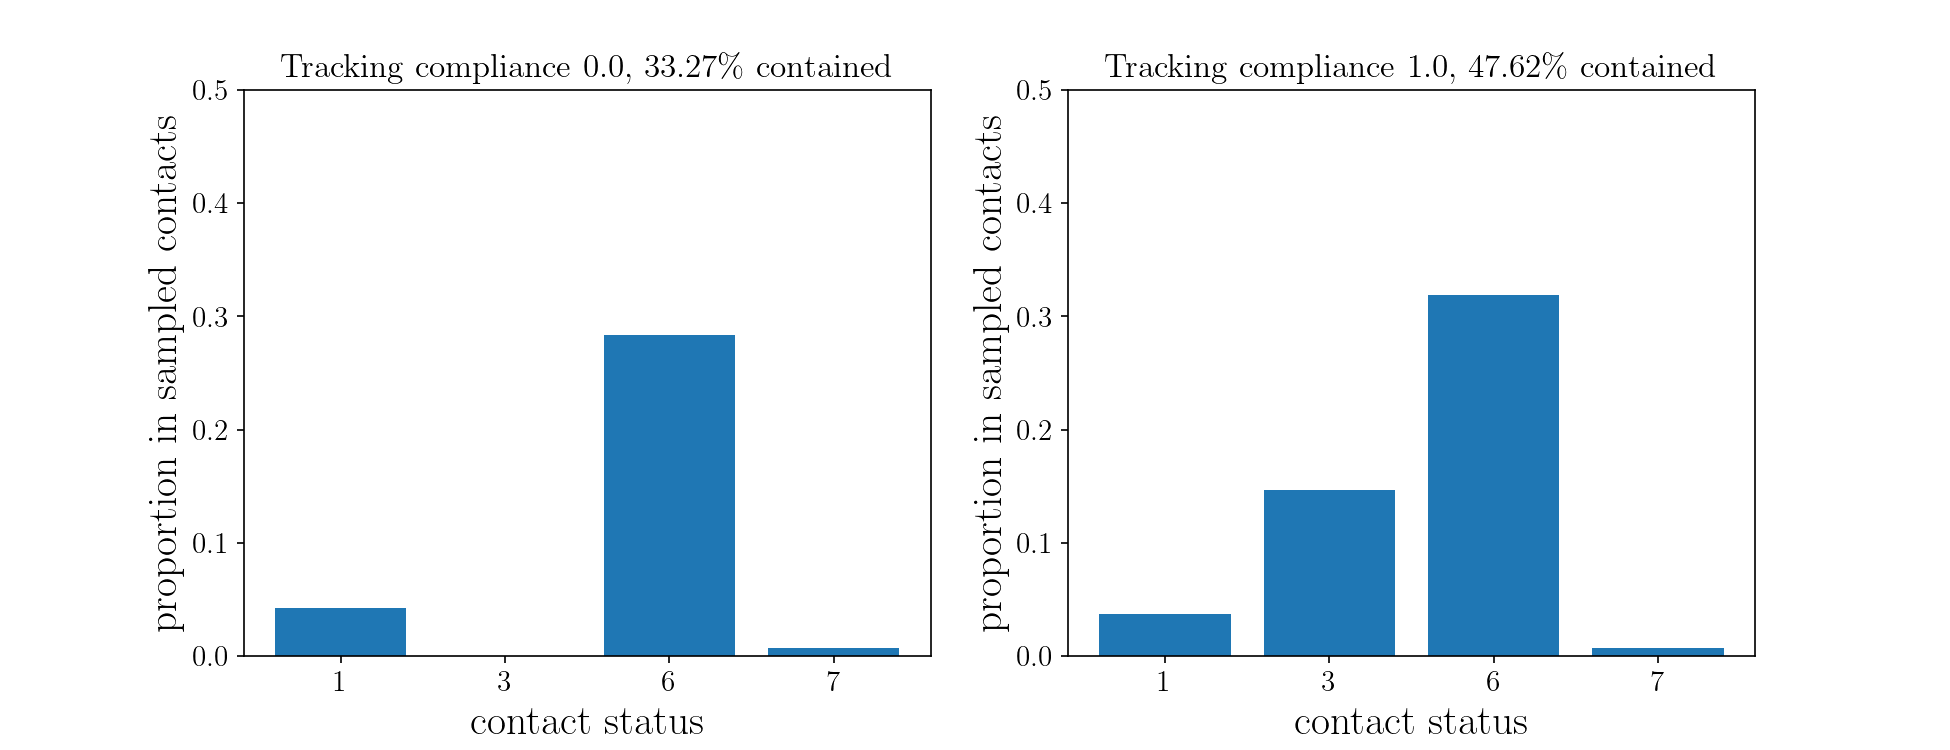

In [4]:
'''
(0) 0: SocialDistancingForAllMeasure`
(1) 1: SocialDistancingForPositiveMeasure
(2) 2: SocialDistancingByAgeMeasure`
(3) 3: SocialDistancingForSmartTracing
(4) 4: SocialDistancingForKGroups`
(5) 5: UpperBoundCasesSocialDistancing`
(6) 'resi/dead'
(7) 'hosp'
(8) 'site_measures'
(9) not contained
'''
import matplotlib.pyplot as plt
rpts = 2
p_compliance = [0.0, 1.0]
measures_deployed = [1,3,6,7]
summaries_SD_6 = load_summary('summaries_SD_5.pk')
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    f,axs = plt.subplots(1,2,figsize = (13,5))
    for s, summary in enumerate(summaries_):
        counts = np.zeros((10,))
        num_contacts = 0
        for r in range(rpts):
            num_contacts += len(summary.mob[r])
            for contact in summary.mob[r]:                
                if (not contact.data['i_contained']) and (not contact.data['j_contained'] ):
                    counts[9] += 1
                else:
                    for i in range(6):
                        if (i in contact.data['i_contained_by']) or (i in contact.data['j_contained_by']):
                            counts[i] += 1
                    if ('resi/dead' in contact.data['i_contained_by']) or ('resi/dead' in contact.data['j_contained_by']):
                        counts[6] += 1
                    if ('hosp' in contact.data['i_contained_by']) or ('hosp' in contact.data['j_contained_by']):
                        counts[7] += 1
                    if ('site_measures' in contact.data['i_contained_by']) or ('site_measures' in contact.data['j_contained_by']):
                        counts[8] += 1
        counts /= num_contacts
        axs[s].bar(range(1,len(measures_deployed)+1),counts[measures_deployed])
        axs[s].set_title('Tracking compliance '+str(p_compliance[s])+', '+ str(round((1-counts[9])*100,2))+'\% contained')
        axs[s].set_xlabel('contact status',fontsize = 20)
        axs[s].set_ylabel('proportion in sampled contacts',fontsize = 20)
        axs[s].set_xticks(range(1,len(measures_deployed)+1))
        axs[s].set_xticklabels(measures_deployed)
        axs[s].set_ylim(0,0.5)
#plt.tight_layout()
#plt.savefig('plots/contact_details.png',dpi=300)
plt.show()

In [ ]:
# TODO: Plot results of experiments_essential_fixed.py
c=0
runstr = f'run{c}_'
summaries_SD_6 = load_summary('summaries_r8.pk')
FIGSIZE=(6, 4)

p_compliance = [0.0, 0.25, 0.5, 0.75, 1.0]
plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['random', 'essential']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' individuals compliant with contact-tracing'),
        filename=runstr + f'SD_6{j}', 
        figsize=FIGSIZE, acc=500, 
        ymax=2000, errorevery=14)